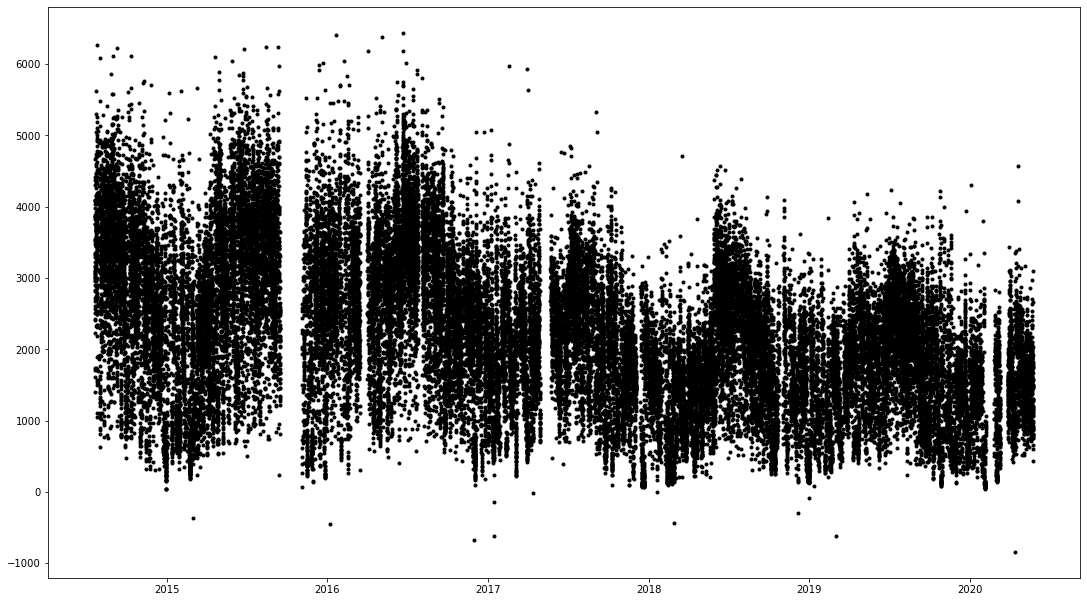

In [1]:
from EddyData import EddyData
import numpy as np
import matplotlib.pylab as plt

data = EddyData('data/HSL_data.csv')
data.filter_by_ustar(0.3)
data.denoise('co2_flux')
co2_ts = data.co2_flux
t = data.time

import pickle as p
p.dump(data, open('results/ec_data_object.p', 'wb'))

plt.plot(t,co2_ts,'k.')
plt.gcf().set_size_inches(18.5, 10.5)

In [2]:
def periodic_signal(t, wl):
    
    t_days = (t-min(t)).astype('timedelta64[s]').astype(np.float64)/(60.0*60.0*24.0)
    
    def inner_function(A1, A2):
        return A1 * np.cos(2.0*np.pi*t_days/wl) + A2 * np.sin(2.0*np.pi*t_days/wl)
    
    return inner_function

In [3]:
from scipy.special import erf

def erfc_signal(t):
    
    t_days = (t-min(t)).astype('timedelta64[s]').astype(np.float64)/(60.0*60.0*24.0)
    
    def inner_function(A, tc, tstar):
        return A*(1 - erf((t_days - tc) / tstar))
    
    return inner_function

In [4]:
def total_signal(t, wl1, wl2, wl3):
    
    periodic1 = periodic_signal(t, wl1)
    periodic2 = periodic_signal(t, wl2)
    periodic3 = periodic_signal(t, wl3)
    
    erfc = erfc_signal(t)
    
    def inner_function(x):
        (A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b) = x
        return periodic1(A1s1, A2s1) + periodic2(A1s2, A2s2) + periodic3(A1s3, A2s3) + erfc(Aerfc, tc, tstar) + b
    
    return inner_function

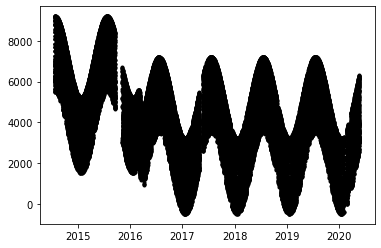

In [5]:
# Test:

A1s1 = 1000.0
A2s1 = 500
wl1 = 0.5

A1s2 = 1000.0
A2s2 = 500
wl2 = 1.0

A1s3 = 2000.0
A2s3 = 0
wl3 = 365.0

Aerfc = 1000.0
tc = 600.0
tstar = 10.0

b = 3000.0

model = total_signal(t, wl1, wl2, wl3)

plt.plot(t, model((A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b)), 'k.')


In [6]:
def model_misfit(t, co2_flux_obs, wl1, wl2, wl3):
    
    model = total_signal(t, wl1, wl2, wl3)
    
    def inner_function(x):
        return np.sum(np.power(model(x) - co2_flux_obs, 2))
    
    return inner_function

In [7]:
x0 = (A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b)

from scipy.optimize import fmin

optimize_function = model_misfit(t, co2_ts, wl1, wl2, wl3)
x = fmin(optimize_function, x0, maxfun = 1E12)

Optimization terminated successfully.
         Current function value: 33151250827.865566
         Iterations: 2682
         Function evaluations: 3816


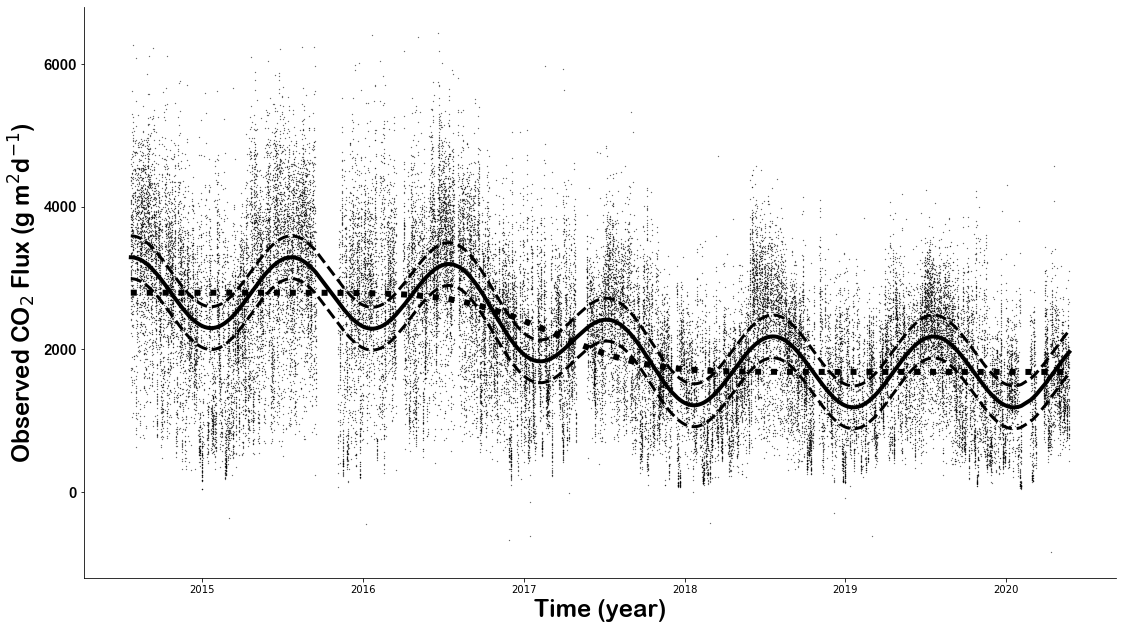

In [60]:
(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b) = x

model = total_signal(t, wl1, wl2, wl3)
erfc_model = erfc_signal(t)
co2_erfc_pred = erfc_model(Aerfc, tc, tstar)

co2_pred = model(x)

Amag_s1 = np.sqrt(np.power(A1s1, 2) + np.power(A2s1, 2))
Amag_s2 = np.sqrt(np.power(A1s1, 2) + np.power(A2s2, 2))

x_nodiurnal = (0.0, 0.0, 0.0, 0.0, A1s3, A2s3, Aerfc, tc, tstar, 0.0)
co2_nodiurnal = model(x_nodiurnal)

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.plot(t, co2_ts,'k.', markersize = 0.5)
#plt.plot(t, co2_pred,'g-')
plt.plot(t, co2_erfc_pred + b, 'k:', linewidth = 6)
plt.plot(t, co2_nodiurnal + b + Amag_s1 + Amag_s2, 'k--', linewidth = 3)
plt.plot(t, co2_nodiurnal + b - Amag_s1 - Amag_s2, 'k--', linewidth = 3)
plt.plot(t, co2_nodiurnal + b, 'k-', linewidth = 4)
plt.yticks(np.arange(0, 8000, 2000))
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 14})
plt.xlabel('Time (year)', fontname = "Arial Rounded MT Bold", fontsize = 24)
plt.ylabel('Observed CO$_{2}$ Flux (g m$^{2}$d$^{-1}$)', fontname = "Arial Rounded MT Bold", fontsize = 24)
plt.gca().axis('tight')

plt.gcf().set_size_inches(18.5, 10.5)
plt.savefig('results/Figure2.eps', format='eps')

In [9]:
import pickle as p

p.dump((t, co2_ts, co2_pred, co2_erfc_pred, b), open('results/ec_time_series.p', 'wb'))

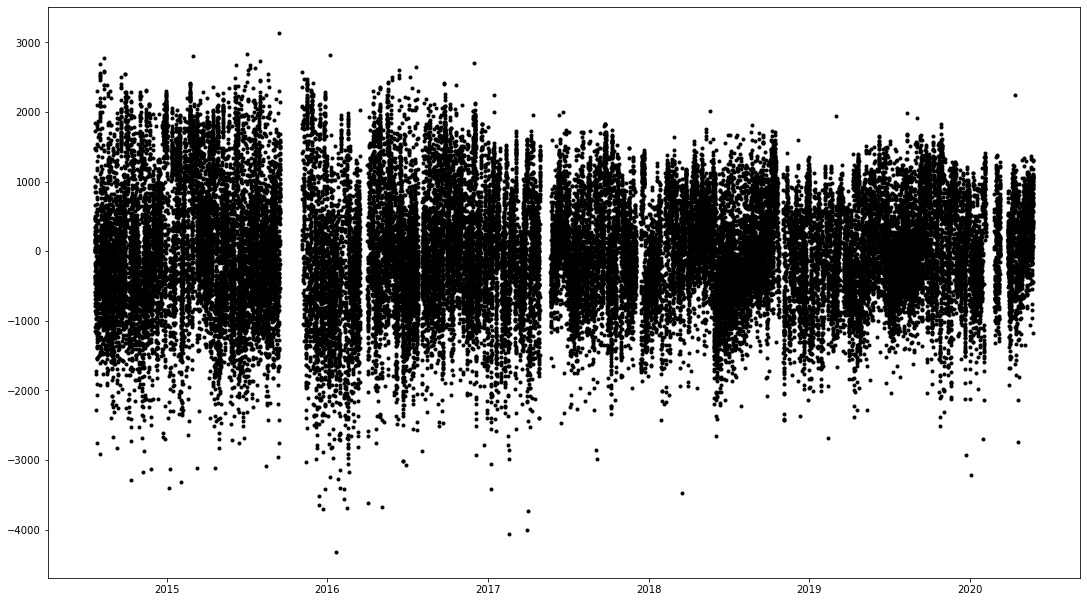

In [10]:
plt.plot(t, co2_pred - co2_ts, 'k.')
plt.gcf().set_size_inches(18.5, 10.5)

In [11]:
(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b) = x

A1 = np.sqrt(np.power(A1s1,2) + np.power(A2s1,2))
A2 = np.sqrt(np.power(A1s2,2) + np.power(A2s2,2))
A3 = np.sqrt(np.power(A1s3,2) + np.power(A2s3,2))

print('Semi-diurnal amplitude: ', A1)
print('Diurnal amplitude: ', A2)
print('Annual amplitude: ', A3)

print('\n')

print('t_c: ', np.array([tc*60.0*60.0*24.0]).astype('timedelta64[s]') + min(t))
print('tstar: ', tstar / 365.0)
print('Amplitude of secular change: ', Aerfc)

print('\n')

print('Offset: ', b)

Semi-diurnal amplitude:  175.9339931674851
Diurnal amplitude:  123.66797255078217
Annual amplitude:  496.6765565549413


t_c:  ['2017-03-03T11:39:45']
tstar:  0.6461280414610028
Amplitude of secular change:  555.6309663464663


Offset:  1682.9293726166657


In [14]:
print("Std of residuals:", np.std(co2_pred - co2_ts))

Std of residuals: 824.3408183064547
